# Fine-tuning VGG Network.

In this hometask you'll need to fine-tune VGG network for dogs classification (the same dataset as in practical seminar).

## Loading the data

In [ ]:
# this cell downloads zip archive with data
! wget "https://www.dropbox.com/s/r11z0ugf2mezxvi/dogs.zip?dl=0" -O dogs.zip

--2025-02-26 17:26:13--  https://www.dropbox.com/s/r11z0ugf2mezxvi/dogs.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/cgwxt4jlpesmb9oq9s19f/dogs.zip?rlkey=ysuiqksb7i8ewm117m5e7lqxh&dl=0 [following]
--2025-02-26 17:26:13--  https://www.dropbox.com/scl/fi/cgwxt4jlpesmb9oq9s19f/dogs.zip?rlkey=ysuiqksb7i8ewm117m5e7lqxh&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc402f230979ce5b0bb0f0e2579a.dl.dropboxusercontent.com/cd/0/inline/Ck0-ImGyTDid1LG8evi9bYKT3wXSTbprPVFl9R5vllzlQSixeisyzHH3N6brvc_ttkyt4ajb8WcdgAkqfXtIwD_wpgdTkpsC49FnPmLMAQNgjnm9oVIMQvegLqCxmKZAq9qS-ouQ1jhOg4nczLgF-tAe/file# [following]
--2025-02-26 17:26:14--  https://uc402f230979ce5b0bb0f0e2579a.dl.dropboxusercontent.com/cd/0/inlin

In [ ]:
# this cell extract the archive. You'll now have "dogs" folder in colab
! unzip -qq dogs.zip

## Task 1

Your task is to fine-tune [VGG11 ](https://pytorch.org/vision/0.20/models/generated/torchvision.models.vgg11.html) network from torchvision for the task of dogs breed classification. Your task is to tune the model so that it has the best test accuracy possible. You are not allowed to use any other pretrained model except this and any other data except given.

What you can do:
- **Preprocess and augment data**. Note the following: there is a difference between ordinary data preprocessing (as we did in the practical session) and augmentation. Preprocessing usually refers to the way all the data (train and test) is processed before feeding into the network; augmentation is a technique used to populate training set of samples. Augmentation should only be used on training data, but not on validation and test data. You can read more about augmentation [here](https://d2l.ai/chapter_computer-vision/image-augmentation.html). Also think about what kind of image augmentations are suitable for the given task, e.g. would that be beneficial to flip images vertically in our case?
- **Change/remove/add layers to the network**. You can change layers of the pre-trained VGG11. Note, however, that newly added layers should not be pre-trained. You are allowed to add any layers, e.g. conv, fc, dropout, batchnorm
- **Tune hyperparameters**, e.g. batch size, learning rate, etc.

If X is your score on test set, them your task score is calculated as follows: min(0.95, (X-0.75))*5

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.metrics import f1_score

from tqdm.auto import tqdm

from IPython.display import clear_output

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import random
from PIL import Image


def set_all_seeds(seed=42):
    # Устанавливаем seed для встроенного генератора Python
    random.seed(seed)
    # Устанавливаем seed для хэш-функции Python (опция для контроля поведения хэшей)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Устанавливаем seed для NumPy
    np.random.seed(seed)

    # Устанавливаем seed для PyTorch
    torch.manual_seed(seed)
    # Устанавливаем seed для генератора на CUDA
    torch.cuda.manual_seed(seed)
    # Отключаем недетерминированное поведение в алгоритмах CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_all_seeds()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torchvision import models
import os

In [ ]:
train_dir = r'dogs/train'
val_dir = r'dogs/valid'
test_dir = r'dogs/test'

In [ ]:
classes = os.listdir(train_dir)

In [ ]:
paths_lst_train = []
class_lst_train = []
for t in classes:
    pth_class = os.path.join(train_dir, t)
    for p in os.listdir(pth_class):
        paths_lst_train.append(os.path.join(pth_class, p))
        class_lst_train.append(t)

In [ ]:
paths_lst_val = []
class_lst_val = []
for t in classes:
    pth_class = os.path.join(train_dir, t)
    for p in os.listdir(pth_class):
        paths_lst_val.append(os.path.join(pth_class, p))
        class_lst_val.append(t)

In [ ]:
paths_lst_test = []
class_lst_test = []
for t in classes:
    pth_class = os.path.join(train_dir, t)
    for p in os.listdir(pth_class):
        paths_lst_test.append(os.path.join(pth_class, p))
        class_lst_test.append(t)

In [ ]:
dct_class_in = {classes[t]: t for t in range(len(classes))}
dct_class_out = {y: x for x, y in dct_class_in.items()}

In [ ]:
class_lst_train_id = [dct_class_in[x] for x in class_lst_train]
class_lst_val_id = [dct_class_in[x] for x in class_lst_val]
class_lst_test_id = [dct_class_in[x] for x in class_lst_test]

In [ ]:
class DogDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        :param image_paths: список путей к изображениям
        :param labels: список меток классов
        :param transform: аугментации (если None, то применяются стандартные)
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform if transform else self.default_transforms()

    def default_transforms(self):
        """Стандартные аугментации для обучения"""
        return transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
from torchvision import transforms

train_aug = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Больше изменений масштаба
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Добавлен поворот ±15 градусов
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Более агрессивный ColorJitter
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Добавлен Gaussian Blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet нормализация
])

test_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet нормализация
])


In [ ]:
trainset = DogDataset(paths_lst_train, class_lst_train_id, train_aug)
valset = DogDataset(paths_lst_val, class_lst_val_id, test_aug)
testset = DogDataset(paths_lst_test, class_lst_test_id, test_aug)

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from IPython.display import clear_output

def train(model, train_loader, val_loader, criterion, optimizer, num_epoch):
    model.to(device)
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}
    best_model = None

    for epoch in tqdm(range(num_epoch)):
        model.train()
        total_loss = 0
        for X, y in tqdm(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X, y in tqdm(val_loader):
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()

        clear_output(wait=True)
        plt.plot(history["train_loss"], label="Train Loss")
        plt.plot(history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss")
        plt.show()

    model.load_state_dict(best_model)
    return model, history


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate(model, loader, criterion):
    '''
    args:
        model - our neural network model
        loader — structure which yields batches of test data
        criterion - loss function from `torch.nn` module
        device - the device where the model and data should be placed (e.g., 'cuda' or 'cpu')
    '''

    losses = []
    y_pred_list = []
    y_true_list = []

    model.eval()

    for X_batch, y_batch in tqdm(loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        with torch.no_grad():
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            losses.append(loss.item())

        _, y_pred_class = torch.max(y_pred, dim=1)

        y_pred_list.extend(y_pred_class.cpu().numpy())  # move to CPU if using CUDA
        y_true_list.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(y_true_list, y_pred_list)

    return np.mean(losses), accuracy

In [ ]:
def get_modified_vgg11(num_classes=70, pretrained=True):
    # Загружаем предобученную VGG11
    model = models.vgg11(pretrained=pretrained)

    # Замораживаем все сверточные слои
    for param in model.features.parameters():
        param.requires_grad = False

    # Изменяем выходной слой классификатора
    model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)

    return model


In [ ]:
len(classes)

70

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = get_modified_vgg11()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
model = torch.nn.DataParallel(model)

In [ ]:
model;

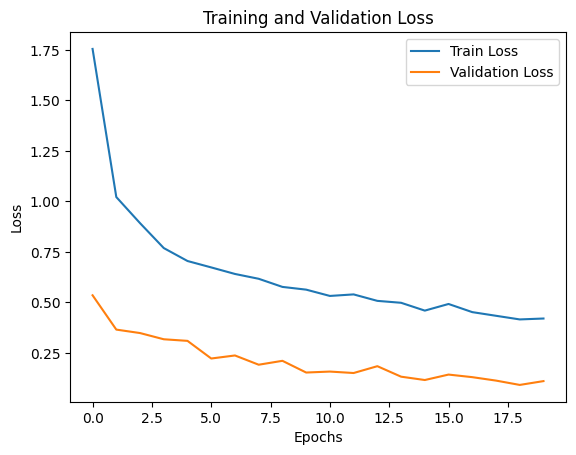

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Функция потерь и оптимизатор
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Запуск обучения
num_epochs = 20
best_net, hist = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)


In [ ]:
evaluate(model, test_loader, criterion)

  0%|          | 0/125 [00:00<?, ?it/s]

(0.11361530065333159, 0.9675308331235842)